In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from datetime import date
import matplotlib.gridspec as gridspec

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

mpl.rcParams['pdf.fonttype'] = 42

sns.set(style="ticks")

%matplotlib inline

In [2]:
# Update the files if the data change
hom_amp_df = pd.read_excel('GluR2_KA_summary211118.xlsx', sheetname='KA 1mM Homomers summary')
het_amp_df = pd.read_excel('GluR2_KA_summary211118.xlsx', sheetname='KA 1mM Heteromers Summary')
het_ramps_df = pd.read_excel('ramps_results_Mar18_fullHet.xlsx')
hom_ramps_df = pd.read_excel('ramps_results_Hom_full.xlsx')

In [3]:
# replace mutants with consistent nomenclature
names = {'PQK528-530Del':'P528-530Del', '528Del':'P528-530Del', 'GRIA1':'—'}
data_frames = [hom_amp_df, het_amp_df, hom_ramps_df, het_ramps_df]

for df in data_frames:
    df['Mutant'] = df['Mutant'].apply(lambda x: names[x] if x in names else x)

# Normalise the rectification ratio

In [23]:
#WT_het_norm = het_ramps_df['RI'][het_ramps_df['Mutant'] == 'WT'].mean()
#het_ramps_df['RI_norm'] = het_ramps_df['RI']/WT_het_norm

def normalise_RI(df):
    WT_mean = df['RI'][df['Mutant'] == 'WT'].mean()
    df['RI_norm'] = 1 - ((df['RI']*-1)/(WT_mean*-1))
    
for df in [hom_ramps_df, het_ramps_df]:
    df = normalise_RI(df)

# Export files (wide data for stats in Prism)

In [5]:
#Tuple that gives the df, the column to extract and the name of the data
export_df_info = ((hom_amp_df,'KA Amplitude','homomer_KAamp'),
                  (het_amp_df,'KA Amplitude','heteromer_KAamp'),
                  (hom_amp_df, 'KA Holding current', 'hom_holding'),
                  (het_amp_df, 'KA Holding current', 'het_holding'),
                  (hom_ramps_df, 'RI', 'homomer_ramps',),
                  (het_ramps_df, 'RI', 'heteromer_ramps',))


def make_excel(project):
    d = date.today().strftime('%y%m%d')
    filename = d+project+'.xlsx'
    File = pd.ExcelWriter(filename)
    return File

def wide_table(df, name, data_col, excel_ob):
    '''data_col specifies the data you want to keep. 
    The function assumes that Mutant will become the index'''
    df = df.pivot(columns='Mutant', values=data_col).apply(lambda x: pd.Series(x.dropna().values))
    df = df.dropna(axis=1, how='all')
    df.to_excel(excel_ob, sheet_name=name, index=False)
    
def export_tables(info_tuple, project='GRIA_wide_data'):
    '''first, initialises an excel object as the save file.
    Then, iterate through the list of df putting each in a new sheet with matching name'''
    file = make_excel(project)
    for df, data_col, name in info_tuple:
        wide_table(df=df, data_col=data_col, name=name, excel_ob=file)
    file.save()
    
export_tables(export_df_info)

#This works beautifully but data are not sorted, Need to sort to make the stats easier
     

# Identify the mutants to include in graphs

In [6]:
# define the mutants that will be included in different figures
# these are in positional order

# total mutants in the paper; needed for colors
all_mutants = ['WT', '—', 'G47E', 'D302G', 'I375V', 'P528T', 'P528-530Del', 'Q607E', 
               'G609R', 'D611N', 'A639S', 'A643T', 'F644L', 'T646N', 'V647L',]

# main figures will exclude non-clinical mutants
main_mutants = ['—', 'WT', 'G47E', 'D302G', 'P528T', 'P528-530Del', 'Q607E', 
               'G609R', 'D611N', 'A639S', 'F644L', 'T646N', 'V647L',]

# non-clinical mutants go in supplemantary: snp and Lurcher
supp_mutants = ['WT', '—', 'I375V', 'A643T']

15


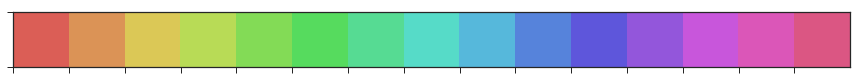

In [7]:
# Assign a consistent colorscheme:
rgb15 = sns.color_palette('hls', n_colors=15)
print(len(rgb15))
sns.palplot(rgb15)

#'Paired' is also good but only 12

In [8]:
color_dict = dict(zip(all_mutants, rgb15))

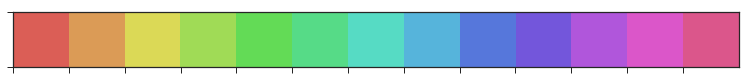

In [9]:
pal2 = sns.color_palette('hls', n_colors=13)
sns.palplot(pal2)

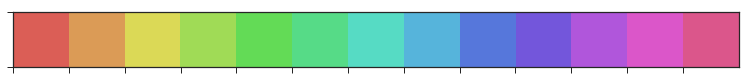

In [10]:
sns.palplot(pal2)

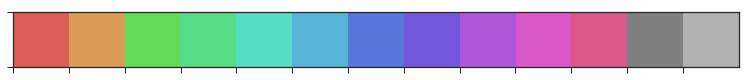

In [11]:
#drop the 2 lightest colors & use grey shades for controls

pal2 = pal2[0:2] + pal2[4:]
color_dict2 = dict(zip(main_mutants[2:], pal2))
color_dict2['WT'] = (0.5,0.5,0.5)
color_dict2['—'] = (0.7,0.7,0.7)

sns.palplot(color_dict2.values())

In [25]:
color_dict2

{'A639S': (0.45119999999999971, 0.33999999999999997, 0.85999999999999999),
 'D302G': (0.85999999999999999, 0.61119999999999997, 0.33999999999999997),
 'D611N': (0.33999999999999997, 0.46879999999999972, 0.85999999999999999),
 'F644L': (0.69120000000000026, 0.33999999999999997, 0.85999999999999999),
 'G47E': (0.85999999999999999, 0.37119999999999997, 0.33999999999999997),
 'G609R': (0.33999999999999997, 0.70879999999999954, 0.85999999999999999),
 'P528-530Del': (0.33999999999999997,
  0.85999999999999999,
  0.53120000000000012),
 'P528T': (0.38880000000000003, 0.85999999999999999, 0.33999999999999997),
 'Q607E': (0.33999999999999997, 0.85999999999999999, 0.77120000000000011),
 'T646N': (0.85999999999999999, 0.33999999999999997, 0.78879999999999928),
 'V647L': (0.85999999999999999, 0.33999999999999997, 0.54879999999999951),
 'WT': (0.5, 0.5, 0.5),
 '—': (0.7, 0.7, 0.7)}

# Plot & save functions

In [12]:
# Put all the plotting in one function

def save_fig(name, fig_object):
    d = date.today().strftime('%y%m%d')
    filename = d+name+'.pdf'
    plt.savefig(filename, transparent=True)
    pass

    
def sem_ordered(df, x, y, order):
    sem_df = df.groupby(x)[y].sem()
    sem_list = []
    for m in order:
        sem_list.append(sem_df[m])
    return sem_list
    

def barplot_swarmplot_format(df, x, y, title, ylabel='Amplitude (nA)', fontsize=16, order=main_mutants, pal=color_dict2,
                            convert_pA=True): 
    ''''''
    if convert_pA & max(df[y] > 10): #changes the underlying df, so helpful to check if it was already converted
        df[y]=df[y]/1000
        
    yerr = sem_ordered(df=df, x=x, y=y, order=order)
    sns.barplot(x=df[x], y=df[y], ci=None, order=order, alpha=1, palette=color_dict2, yerr=yerr, capsize=20)
    sns.swarmplot(x=df[x], y=df[y], color='k', size=3.5, order=order)
    
    sns.set_style("ticks", {"axes.linewidth": 1})
    plt.xticks(range(len(order)), order, rotation=45, size=fontsize, ha='right')
    plt.xlabel('')
    plt.yticks(size=fontsize)
    plt.ylabel(ylabel, size=fontsize)
    sns.despine()
    plt.tight_layout()
    plt.title(title, size=fontsize)
    pass


# Figure 1: homomer amplitude

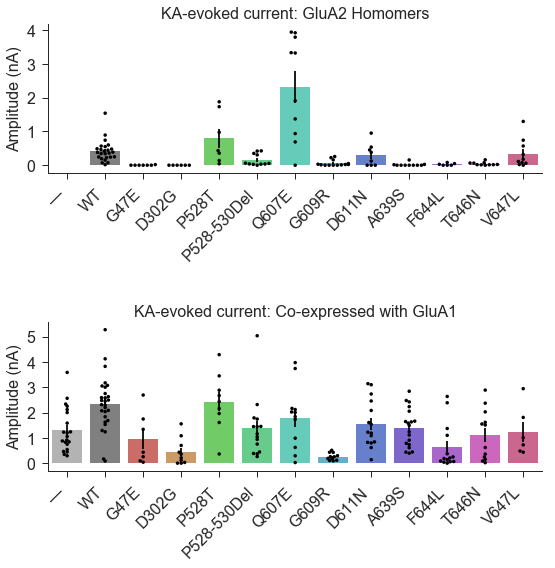

In [35]:
# make figure 1
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
barplot_swarmplot_format(df=hom_amp_df, x='Mutant', y='KA Amplitude', title='KA-evoked current: GluA2 Homomers')

ax2 = plt.subplot(212)
barplot_swarmplot_format(df=het_amp_df, x='Mutant', y='KA Amplitude', title='KA-evoked current: Co-expressed with GluA1')

plt.subplots_adjust(hspace=1)

#plt.savefig('Amplitude_resub_March_Color.pdf', transparent=True)
save_fig('Amplitude_resub_', fig)

plt.show()

# figure S1: Other mutants

# figure S1: holding current

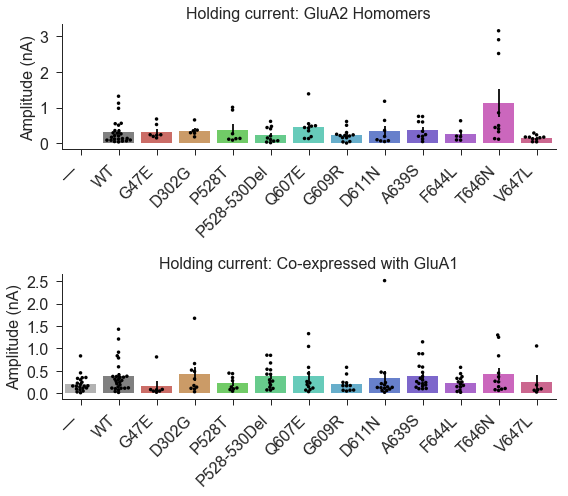

In [68]:
fig = plt.figure(figsize=(8,7))
ax1 = plt.subplot(211)
barplot_swarmplot_format(df=hom_amp_df, x='Mutant', y='KA Holding current', title='Holding current: GluA2 Homomers')

ax2 = plt.subplot(212)
barplot_swarmplot_format(df=het_amp_df, x='Mutant', y='KA Holding current', title='Holding current: Co-expressed with GluA1')

plt.subplots_adjust(hspace=1)

#plt.savefig('Amplitude_resub_March_Color.pdf', transparent=True)
save_fig('Holding_resub', fig)

plt.show()

# Figure 3a: plot ramps with appropriate colors

In [64]:
# Function for plotting each ramp
# Then function for plotting each of a list of ramps as a subplot

def graph_ramp(df, m, i, fig, col, sub):
    '''Makes the individual ramp plot for each mutant'''
    
    sns.set_style("ticks")
    ax = fig.add_subplot(4,4,sub) # bank of 16 subplots. May need to change this
    # spec = gridspec.GridSpec(4,4,fig)
    # use the number of columns to figure out 
    
    #ax = fig.add_subplot(spec[sub])
    
    mV_ms = 180/1800   # gradient of the ramp protocol that was used in the recording
    x_ms = np.array(range(0,1800))
    x_mV = (x_ms*mV_ms)-104   #-100 because the ramp started at -100, then also -4 to correct for LJP

    plt.plot(x_mV[2:], df['mean'].iloc[1002:2800], color=col, lw=3)
    plt.plot(x_mV[2:], df['pos_error'].iloc[1002:2800], color=col, alpha = 0.8, lw=1)
    plt.plot(x_mV[2:], df['neg_error'].iloc[1002:2800], color=col, alpha = 0.8, lw=1)
    
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    plt.xticks(np.arange(-70, 100, step=110), size=12)
    plt.yticks(np.arange(-2, 2.1, step=4), size=12)
    
    plt.axhline(0, color='black', alpha=1, lw=1)
    plt.axvline(0, color='black', alpha=1, lw=1)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.title('     '+m, size=16)
    plt.ylim(-3.2, 2.500)
    pass




def plot_many_ramps(ramps_df, Mutant_list, figsize=(14,14), color_dict=color_dict2):
    fig = plt.figure(figsize=figsize)

    for i, m in enumerate(Mutant_list):
        title = m + ' subtracted ramps'
        df_to_plot = pd.DataFrame()
        file_list = ramps_df['File'][ramps_df['Mutant'] == m]
        for f in file_list:
            name = f + ".EDRRampSummary.csv"
            df = pd.read_csv(name)
            df_to_plot[f] = df['Subtracted']

        if m == 'GRIA1':
            label = '—'
        elif m == '528Del':
            label = 'P528-530Del'
        else:
            label = m

        data_col = df_to_plot.columns
        df_to_plot['mean'] = df_to_plot.aggregate('mean', axis=1)/1000 #convert from pA to nA
        df_to_plot['SEM'] = df_to_plot[data_col].aggregate('sem', axis=1)/1000
        df_to_plot['pos_error'] = df_to_plot['mean']+df_to_plot['SEM']
        df_to_plot['neg_error'] = df_to_plot['mean']-df_to_plot['SEM']

        color = color_dict[label]

        graph_ramp(df_to_plot, label, i, fig, col=color, sub=subplots[m])

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    return fig


In [65]:
# dictionary defines which mutant goes to which subplot

subplots = dict(zip(main_mutants,list(range(1,len(main_mutants)+1))))

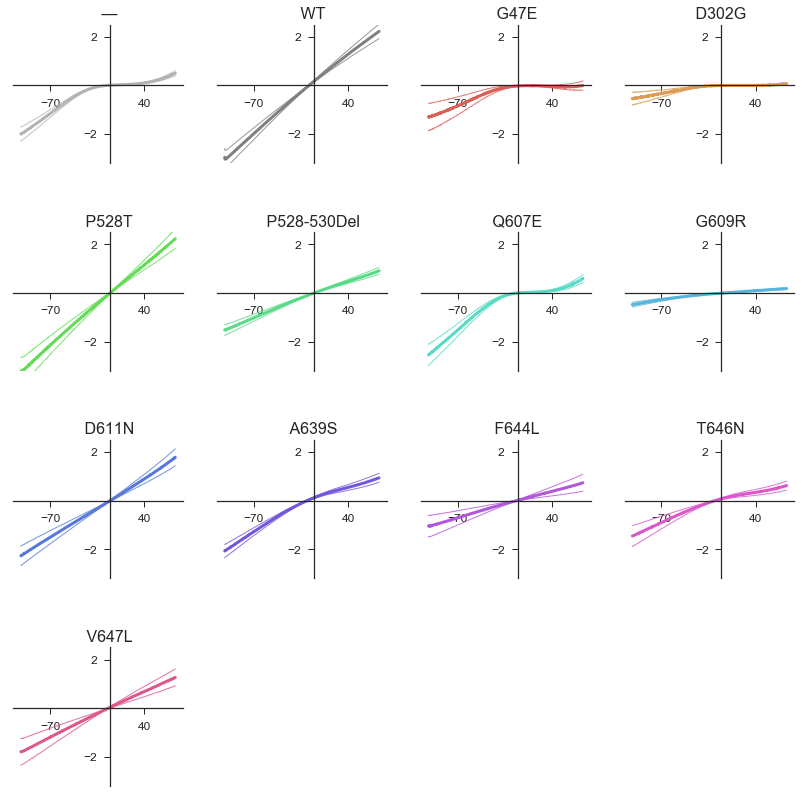

In [66]:
het_ramps_fig = plot_many_ramps(het_ramps_df, main_mutants)

# Figure 3b: with ramps, summarise RI

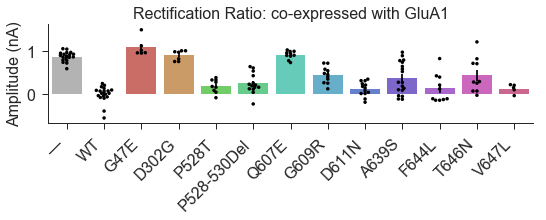

In [33]:
# current at +40 as a percent of -70, normalised to WT

# How do we put this into the previous figure?

fig = plt.figure(figsize=(8,3))

barplot_swarmplot_format(df=het_ramps_df, x='Mutant', y='RI_norm', title='Rectification Ratio: co-expressed with GluA1', 
                         convert_pA=False)

save_fig('ramps_resub', fig)

plt.show()

# Figure 4: Plot the RI against the amplitude

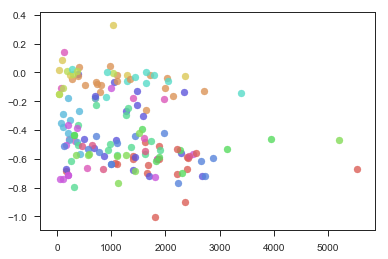

In [16]:
##Plotting indivudual cells shows little correlation between RI and amplitude

for row in range(len(het_ramps_df)):
    data = het_ramps_df.iloc[row]
    x = data['-70mV I']*-1
    y = data['RI']
    m = data['Mutant']

    if m in color_dict.keys():
        c = color_dict[m]
        plt.scatter(x,y,color=c,alpha=0.8)


plt.show()

In [17]:
ramps_paper = het_ramps_df[het_ramps_df['Mutant'] != 'W788L']
DK_scatter = ramps_paper.groupby('Mutant')[['-70mV I','RI']].mean()
DK_scatter.head(3)

,-70mV I,RI
Mutant,,
A639S,-1283.597463,-0.403514
D302G,-295.668858,-0.058419
D611N,-1475.631682,-0.564678


In [18]:
# Need to add in the statistics here. Maybe 528T has a sig reduced RI?

DK_error = ramps_paper.groupby('Mutant')[['-70mV I','RI']].sem()

In [19]:
DK_error.columns

Index(['-70mV I', 'RI'], dtype='object')

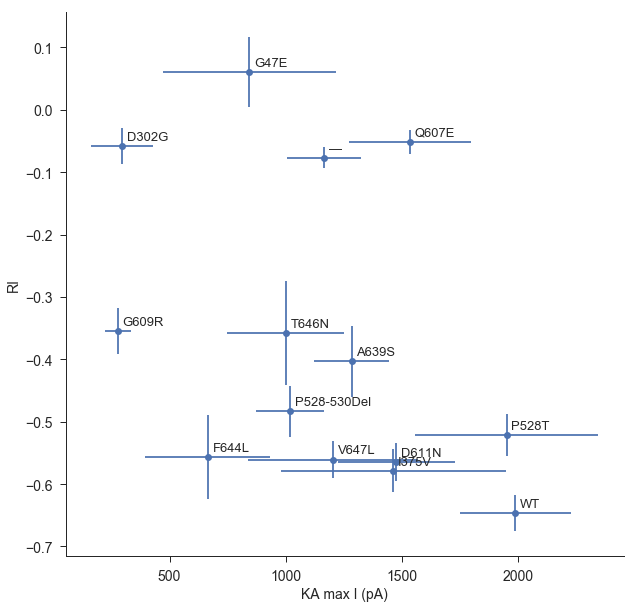

In [20]:


fig = plt.figure(figsize=(10,10
                         ))

#plt.scatter(x=DK_scatter['-70mV I']*-1, y=DK_scatter['RI'])
plt.xlabel('KA max I (pA)', fontsize=14)
plt.ylabel('RI', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.errorbar(x=DK_scatter['-70mV I']*-1, y=DK_scatter['RI'], xerr=DK_error['-70mV I'], 
             yerr=DK_error['RI'], fmt='o', alpha=1, )

#add tags
for row in range(len(DK_scatter)):
    label = DK_scatter.index[row]
    x = DK_scatter['-70mV I'][row]
    y = DK_scatter['RI'][row]
    plt.text((x*-1)+20,y+0.01,label, fontsize=13)
   
    
sns.despine()
plt.savefig('MaxI_vsRI_resub_draft.pdf')
plt.show()

In [21]:

    
mutant_order = ['WT', 'G609R', 'A639S', 'T646N']
paper_mutants = ['WT', 'GRIA1', 'G609R', 'A639S', 'T646N']

df_plot = df[df['Mutant'].isin(paper_mutants)]

poster_pal_UCL = {'WT':'#0097a9', 'GRIA1':'#d50032', 'G609R':'#f6be00', 'A639S':'#8f993e', 'T646N':'#500778'} #only used for poster

plt.figure(figsize=(3.5,4))
fig = sns.swarmplot(x=df_plot['Mutant'], y=(df_plot['KA Amplitude']/1000), order=mutant_order, color='black')
swarmplot_format(xlabels=('WT', 'G609R', 'A639S', 'T646N'))


#Annotation:

y = (df_plot['KA Amplitude'][df_plot['Mutant']=='G609R'].max())/1000
h = y*3.5

signif = ['', '***', '***', '***']
sig_stars(h, signif, color='red', size=20)

for label in fig.get_yticklabels()[::2]:
    label.set_visible(False)

plt.savefig('G2_homomers_paper_small.pdf')
plt.show()


TypeError: 'NoneType' object is not subscriptable

In [ ]:
#Take the 2 columns we need to graph
Amp = df[['Mutant', 'KA Amplitude']]
Hold = df[['Mutant', 'KA Holding current']]

In [ ]:
AmpG = Amp.groupby('Mutant')
HoldG = Hold.groupby('Mutant')

In [ ]:
A = AmpG.agg(['mean', 'sem'])
H = HoldG.agg(['mean', 'sem', 'count'])
summary = pd.concat([A,H], axis=1).round(0)
#concatenate the 2 df, matching the axis(??) then remove the decimals with round